# Operacje początkowe

In [1]:
#from google.colab import drive
#from google.colab import output

#drive.mount('/gdrive')
#%cd "/gdrive/My Drive/inz"

In [2]:
#!pip install andi-datasets
#!pip install fbm

In [3]:
import andi
import matplotlib.pyplot as plt
### do wyciągania danych
import pandas as pd
from numpy import log, exp, mean, var
from numpy import linalg as LA
### do ML
import sklearn as sk

In [4]:
AD = andi.andi_datasets()

# Generowanie trajektorii

## Funkcje.

In [5]:
def generate_trajectories(N, models, T, expo):
  '''Models:
  'attm', 'ctrw', 'fbm', 'lw', 'sbm'''
  trajectories = AD.create_dataset(T = T,
                                   N = N,
                                   exponents = expo,
                                   models = models,
                                   dimension=2,
                                   save_trajectories = True,
                                   path = 'data/')
      

In [6]:
def noise_trajectories(N, models, T, expo, SNR):
  '''Dodaje szum gaussa do trajektorii.
  Zwrac: trajektoria bez szumu, trajektoria z szumem'''
  trajectories = AD.create_dataset(T = T,
                                   N = N,
                                   exponents = expo,
                                   models = models,
                                   dimension=2,
                                   load_trajectories = True,
                                   path = 'data/')
  noisy_trajectories = AD.create_noisy_localization_dataset(dataset = trajectories.copy(),
                                                            T = T,
                                                            N = N,
                                                            exponents = expo,
                                                            models = models,
                                                            dimension=2,
                                                            mu=0,
                                                            sigma=1/SNR)
  return trajectories, noisy_trajectories

## Generowanie.

In [7]:
## Generowanie trajektorii długich (T=100)
N=100
# CTRW a \in {0.1, 0,2, ..., 1}
model = 1 # CTRW
T=100
generate_trajectories(N, model, T, [0.1*i for i in range(1,11)])
# FBM a \in {0.25, 0.4, ..., 1.6}
model = 2 # FBM
T=100
generate_trajectories(N, model, T, [0.1+0.15*i for i in range(1,11)])

# Przygotowanie danych

W każdej funkcji:
- x - wektor pozycji $x_i$
- y - wektor pozycji $y_i$
- T - ilość kroków trajektorii

In [8]:
def movement_to_steps(x,y,T):
  ''' Zwraca krok zamiast pozycji.'''
  s_x = []
  s_y = []
  for i in range(1, T):
    s_x.append(x[i] - x[i-1])
    s_y.append(y[i] - y[i-1])
  return s_x, s_y

In [9]:
def norm(x,y, T):
  l = []
  for i in range(T):
    l.append(LA.norm([x[i], y[i]]))
  return l

# TAMSD

In [10]:
def TAMSD(s, T):
  tamsds = [0]
  for n in range(1, T): # gaps
    suma = 0
    for i in range(T - n):
      suma += (s[i+n] - s[i]) ** 2
    tamsds.append( suma / (T - n) )
  return tamsds

# ML

## Wyciąganie danych z trajektorii

Współczynnik dyfuzyjności

In [11]:
def diffusivity(rho1):
  return rho1 / 4

Wydajność

In [12]:
def efficiency(x, y, s, T):
  return (T - 1) * LA.norm([x[-1],y[-1]]) ** 2 / sum([s[i] ** 2 for i in range(T)])

Spowolnienie

In [13]:
def slowdown(n, s):
  return sum(s[-n:]) / sum(s[:n])

Współczynnik MSD

In [14]:
def msd_ratio(tamsds, T):
  kappas = []
  for n in range(T - 1):
    kappas.append(tamsds[n] / tamsds[n+1] - n / (n+1))
  return kappas

Anty-gaussyjność

In [15]:
def TAMSD4(s, T):
  tamsds = [0]
  for n in range(1, T): # gaps
    suma = 0
    for i in range(T - n):
      suma += (s[i+n] - s[i]) ** 4
    tamsds.append( suma / (T - n) )
  return tamsds

def antigaussinity(tamsds, tamsds4):
  Gs = []
  for delt in range(1, T):
    Gs.append(tamsds4[delt] / (2 * tamsds[delt]))
  return Gs

Liniowość

In [16]:
def straightness(s, length):
  return s[-1] / length

Autokrelacja

In [17]:
def autocorr(s, T):
  E = mean(s)
  Var = var(s)
  ds=[s[i] - E for i in range(T)]
  autocor = [1]
  for lag in range(1, T):
    acov = sum([ds[i] * ds[i + lag] for i in range(T-lag)])
    autocor.append(acov / ((T - lag) * Var))
  return autocor

Maksymalna odległość

In [18]:
def max_distance(x, y, T):
  max_d = 0
  for i in range(T):
    for j in range(i, T):
      d = LA.norm([ x[i] - x[j], y[i] - y[j] ])
      if d > max_d:
        max_d = d
  return max_d

Współczynnik uwięzienia

In [19]:
def trappedness(D, T, max_dist):
  return 1-exp(0.2045 - 0.25117 * D * T / (max_dist / 2) ** 2)

Fraktalny wymiar

In [20]:
def fractal_dimension(T, max_dist, length):
  return log(T) / log(T * max_dist / length)

**Get info**

In [21]:
def get_info(traj, T, s_n):
  x = [0, *traj[2:T+2]]                             # położenie x
  y = [0, *traj[T+2:]]                              # położenie y
  s_x, s_y = movement_to_steps(x, y, T+1)           # przesunięcia w x i y
  s = norm(s_x, s_y, T)                             # długości kroków
  length = sum(s)                                   # długość trajektorii (dystans)
  tamsds = TAMSD(s, T)                              # współczynniki TAMSD
  D = diffusivity(tamsds[1])                        # współczynnik dyfuzyjności
  E = efficiency(x, y, s, T)                        # wydajność
  ss = slowdown(s_n, s)                             # współczynnik spowolnienia
  kappas = msd_ratio(tamsds, T)                     # współczynniki MSD dla różnych n
  tamsds4 = TAMSD4(s, T)                            # czasowe średnie odchylenie ^4
  G = antigaussinity(tamsds, tamsds4)               # anty-gaussyjność
  S = straightness(s, length)                       # liniowość
  R = autocorr(s, T)                                # autokorelacja
  max_dist = max_distance(x, y, T + 1)              # maksymalny dystans między punktami
  T = trappedness(D, T + 1, max_dist)               # współczynnik uwięzienia
  frac_dim = fractal_dimension(T + 1, max_dist, length) # wymiar fraktalny
  return D, E, ss, kappas, G, S, R, max_dist, T, frac_dim

In [22]:
def info_all(N, model, T, expo, SNR):
  traj_info = pd.DataFrame(columns=['alpha',
                                    'SNR',
                                    'diffusivity',
                                    'efficiency',
                                    'slowdown',
                                    'MSD_ratio',
                                    'antigaussinity',
                                    'straigthness',
                                    'autocorrelation',
                                    'max_distance',
                                    'trappedness',
                                    'fractal_dim'],
                            index = range(N * len(expo)))
  l_e = 0
  for ex in expo:
    _, noisy = noise_trajectories(N, model, T, ex, SNR)
    l_t = 0
    for traj in noisy:
      if (l_t%50 == 0):
        output.clear()
        print(f"{model} - {l_e}/{len(expo)} - {l_t}/{N}")
      traj_info.loc[N * l_e + l_t] = [ex, SNR, *get_info(traj, T, 10)]
      l_t += 1
    l_e += 1
  return traj_info
T = 100
SNR = 10
N=100
# CTRW
expo_CTRW = [0.1*i for i in range(1,11)]
traj_info_CTRW = info_all(N, 1, T, expo_CTRW, SNR)
output.clear()
print('Zapisywanie do pliku CTRW')
traj_info_CTRW.to_csv('data/pandas_CTRW.csv')
# FBM
expo_FBM = [0.1+0.15*i for i in range(1,11)]
traj_info_CTRW = info_all(N, 2, T, expo_FBM, SNR)
output.clear()
print('Zapisywanie do pliku FBM')
traj_info_CTRW.to_csv('data/pandas_FBM.csv')
output.clear()
print('SKOŃCZONE')

FileNotFoundError: The directory from where you want to load the dataset does not exist

In [ ]:
print("CTRW")
traj_info_CTRW = pd.read_csv('data/pandas_CTRW.csv')
print(traj_info_CTRW)
print("FBM")
traj_info_FBM = pd.read_csv('data/pandas_FBM.csv')
print(traj_info_FBM)

CTRW
     Unnamed: 0  alpha  SNR  ...  max_distance  trappedness  fractal_dim
0             0    0.1   10  ...      2.636319     0.268090     1.841650
1             1    0.1   10  ...      0.729666     0.377455     3.493969
2             2    0.1   10  ...      0.587619     0.569272     3.820913
3             3    0.1   10  ...      0.590622     0.558731     3.814662
4             4    0.1   10  ...      1.980695     0.112381     2.072778
..          ...    ...  ...  ...           ...          ...          ...
995         995    1.0   10  ...     11.349805    -0.039291     1.510171
996         996    1.0   10  ...      4.276546     0.037158     1.718676
997         997    1.0   10  ...      5.302736     0.154599     1.704970
998         998    1.0   10  ...      6.272918     0.154464     1.771371
999         999    1.0   10  ...     11.690180    -0.035142     1.554554

[1000 rows x 13 columns]
FBM
     Unnamed: 0  alpha  SNR  ...  max_distance  trappedness  fractal_dim
0             0 

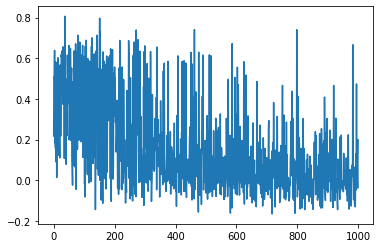